In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import torch
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
from lib import common

In [5]:
pd.options.mode.chained_assignment = None

### Path

In [6]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

### Read Data

In [7]:
train_df, test_df, submission_df = common.read_data(path)

#### Feature generation

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1542 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Patient        1542 non-null   category
 1   Weeks          1542 non-null   int16   
 2   FVC            1542 non-null   int32   
 3   Percent        1542 non-null   float32 
 4   Age            1542 non-null   uint8   
 5   Sex            1542 non-null   category
 6   SmokingStatus  1542 non-null   category
dtypes: category(3), float32(1), int16(1), int32(1), uint8(1)
memory usage: 36.2 KB


In [9]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Patient_Week  730 non-null    category
 1   FVC           730 non-null    int32   
 2   Confidence    730 non-null    int16   
dtypes: category(1), int16(1), int32(1)
memory usage: 31.5 KB


In [10]:
submission_df['Patient'] = submission_df['Patient_Week'].apply(lambda x:x.split('_')[0])
submission_df['Weeks'] = submission_df['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
submission_df = submission_df[['Patient','Weeks','Confidence','Patient_Week']]
submission_df = submission_df.merge(test_df.drop('Weeks', axis=1).copy(), on=['Patient'])

In [11]:
test_df[test_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker


In [12]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610394,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935764,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911224,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377335,73,Male,Ex-smoker


In [13]:
train_df['WHERE'] = 'train'
test_df['WHERE'] = 'val'
submission_df['WHERE'] = 'test'
data = train_df.append([test_df, submission_df])

In [14]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [15]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253647,79,Male,Ex-smoker,train,NaN,NaN,-4.0
1,ID00007637202177411956430,5,2214,55.712128,79,Male,Ex-smoker,train,NaN,NaN,-4.0
2,ID00007637202177411956430,7,2061,51.862103,79,Male,Ex-smoker,train,NaN,NaN,-4.0
3,ID00007637202177411956430,9,2144,53.950680,79,Male,Ex-smoker,train,NaN,NaN,-4.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0
...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,0.0
726,ID00426637202313170790466,130,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,0.0
727,ID00426637202313170790466,131,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,0.0
728,ID00426637202313170790466,132,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,0.0


In [16]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base[base['Patient'] == 'ID00419637202311204720264']

,Patient,min_FVC,nb
1504,ID00419637202311204720264,3020,1


In [17]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
data['base_week'] = data['base_week']
del base

In [18]:
data[data['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week
1498,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,0.0
1499,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,1.0
1500,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,3.0
1501,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,4.0
1502,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker,train,NaN,NaN,6.0,3020,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,ID00419637202311204720264,129,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_129,6.0,3020,1,123.0
1689,ID00419637202311204720264,130,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_130,6.0,3020,1,124.0
1690,ID00419637202311204720264,131,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_131,6.0,3020,1,125.0
1691,ID00419637202311204720264,132,3020,70.186852,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_132,6.0,3020,1,126.0


In [19]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [20]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253647,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,1,0.0,1,0,1,0,0
1,ID00007637202177411956430,5,2214,55.712128,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,1,9.0,1,0,1,0,0
2,ID00007637202177411956430,7,2061,51.862103,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,1,11.0,1,0,1,0,0
3,ID00007637202177411956430,9,2144,53.950680,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,1,13.0,1,0,1,0,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,1,15.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,ID00426637202313170790466,129,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,0.0,2925,1,129.0,1,0,0,1,0
2273,ID00426637202313170790466,130,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,0.0,2925,1,130.0,1,0,0,1,0
2274,ID00426637202313170790466,131,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,0.0,2925,1,131.0,1,0,0,1,0
2275,ID00426637202313170790466,132,2925,71.824966,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,0.0,2925,1,132.0,1,0,0,1,0


In [21]:
# data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
# data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
# data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
# data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
# FE += ['age','percent','week','BASE']

In [23]:
def normalize(df:pd.DataFrame, cont_names, target_names):
    "Compute the means and stds of `self.cont_names` columns to normalize them."
    means, stds = {},{}
    for n, t in zip(cont_names, target_names):
        means[n], stds[n] = df[n].mean(), df[n].std()
        df[t] = (df[n]-means[n]) / (1e-7 + stds[n])

normalize(data, ['Age','min_FVC','base_week','Percent'], ['age','BASE','week','percent'])
FE += ['age','percent','week','BASE']

In [24]:
train_df = data.loc[data.WHERE=='train']
test_df = data.loc[data.WHERE=='val']
submission_df = data.loc[data.WHERE=='test']
del data

In [25]:
train_df.sort_values(['Patient', 'Weeks']).head(15)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253647,79,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,1.638237,-0.636809,-0.876378,-1.142194
1,ID00007637202177411956430,5,2214,55.712128,79,Male,Ex-smoker,train,NaN,NaN,...,9.0,1,0,1,0,0,1.638237,-0.636809,-0.598597,-1.295784
2,ID00007637202177411956430,7,2061,51.862103,79,Male,Ex-smoker,train,NaN,NaN,...,11.0,1,0,1,0,0,1.638237,-0.636809,-0.536868,-1.528450
3,ID00007637202177411956430,9,2144,53.950680,79,Male,Ex-smoker,train,NaN,NaN,...,13.0,1,0,1,0,0,1.638237,-0.636809,-0.475140,-1.402233
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,15.0,1,0,1,0,0,1.638237,-0.636809,-0.413411,-1.516285
5,ID00007637202177411956430,17,2101,52.868645,79,Male,Ex-smoker,train,NaN,NaN,...,21.0,1,0,1,0,0,1.638237,-0.636809,-0.228224,-1.467623
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,33.0,1,0,1,0,0,1.638237,-0.636809,0.142150,-1.621213
7,ID00007637202177411956430,41,2064,51.937595,79,Male,Ex-smoker,train,NaN,NaN,...,45.0,1,0,1,0,0,1.638237,-0.636809,0.512524,-1.523888
8,ID00007637202177411956430,57,2057,51.761448,79,Male,Ex-smoker,train,NaN,NaN,...,61.0,1,0,1,0,0,1.638237,-0.636809,1.006356,-1.534533
9,ID00009637202177434476278,8,3660,85.282875,69,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,0.050822,1.186333,-0.876378,0.491248


In [26]:
X = train_df[FE]
X.head(15)

,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,percent,week,BASE
0,1,0,1,0,0,1.638237,-1.142194,-0.876378,-0.636809
1,1,0,1,0,0,1.638237,-1.295784,-0.598597,-0.636809
2,1,0,1,0,0,1.638237,-1.528450,-0.536868,-0.636809
3,1,0,1,0,0,1.638237,-1.402233,-0.475140,-0.636809
4,1,0,1,0,0,1.638237,-1.516285,-0.413411,-0.636809
5,1,0,1,0,0,1.638237,-1.467623,-0.228224,-0.636809
6,1,0,1,0,0,1.638237,-1.621213,0.142150,-0.636809
7,1,0,1,0,0,1.638237,-1.523888,0.512524,-0.636809
8,1,0,1,0,0,1.638237,-1.534533,1.006356,-0.636809
9,1,0,1,0,0,0.050822,0.491248,-0.876378,1.186333


In [27]:
y = train_df['FVC']
y.shape

(1542,)

#### Seed

In [28]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
seed_everything(42)

### Create Dataset

In [29]:
class ArrayDataset(Dataset):
    
    def __init__(self, x, y):
        self.x, self.y = torch.tensor(x.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32)
        assert(len(self.x) == len(self.y))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __repr__(self):
        return f'x: {self.x.shape} y: {self.y.shape}'

In [30]:
def create_dl(X, y, batch_size=128, num_workers=10):
    ds = ArrayDataset(X, y)
    return DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers)

In [31]:
sample_dl = create_dl(X, y)
x_sample, y_sample = next(iter(sample_dl))
x_sample.shape, y_sample.shape

(torch.Size([128, 9]), torch.Size([128]))

### Prepare neural network

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def move_to_dev(x, y):
    x = x.to(device)
    y  = y.to(device)
    return x, y

In [33]:
C1, C2 = torch.tensor(70, dtype=torch.float32), torch.tensor(1000, dtype=torch.float32)
C1, C2 = move_to_dev(C1, C2)
q = torch.tensor([0.2, 0.50, 0.8]).float().to(device)

def score(y_true, y_pred):
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = torch.max(sigma, C1)
    delta = torch.abs(y_true[:, 0] - fvc_pred)
    delta = torch.min(delta, C2)
    sq2 = torch.sqrt(torch.tensor(2.))
    metric = (delta / sigma_clip)*sq2 + torch.log(sigma_clip* sq2)
    return torch.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    e = y_true - y_pred
    v = torch.max(q*e, (q-1)*e)
    return torch.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        y_true = y_true.unsqueeze(1)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [34]:
class OsicModel(torch.nn.Module):
    def __init__(self, ni, nh1, nh2):
        super(OsicModel, self).__init__()
        self.l1 = nn.Linear(ni, nh1)
        self.l1_bn = nn.BatchNorm1d(nh1, momentum=0.1)
        self.l2 = nn.Linear(nh1, nh2)
        self.p1 = nn.Linear(nh2, 3)
        self.p2 = nn.Linear(nh2, 3)
        
    def forward(self, x):
        x = self.l1(x).clamp(min=0)
        x = self.l1_bn(x)
        x = self.l2(x).clamp(min=0)
        p1 = self.p1(x)
        p2 = self.p2(x).clamp(min=0)
        preds = p1 + torch.cumsum(p2, axis=1)
        return preds

In [35]:
def create_model(nh1=100, nh2=100):
    model = OsicModel(X.shape[1], nh1, nh2)
    model = model.to(device)
    return model

In [36]:
sample_model = create_model()
sample_model

OsicModel(
  (l1): Linear(in_features=9, out_features=100, bias=True)
  (l1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (p1): Linear(in_features=100, out_features=3, bias=True)
  (p2): Linear(in_features=100, out_features=3, bias=True)
)

In [37]:
criterion=mloss(0.8)

In [38]:
# Test model
y_sample, x_sample = move_to_dev(y_sample, x_sample)
output = sample_model(x_sample)
criterion(y_sample, output)

tensor(1082.4044, device='cuda:0', grad_fn=<AddBackward0>)

#### Training functions

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
def eval_loop(valid_dl, model):
    model.eval()
    total_eval_loss = 0
    total_eval_score = 0
    for x, y in valid_dl:
        x, y = move_to_dev(x, y)
        output = model(x)
        loss = criterion(y, output)
        total_eval_loss += loss.item()
        total_eval_score += score(y.unsqueeze(1), output)
        
    avg_val_loss = total_eval_loss / len(valid_dl)
    avg_val_score = total_eval_score / len(valid_dl) * -1
    return {
        'avg_val_loss': avg_val_loss,
        'avg_val_score': avg_val_score
    }

In [41]:
def train_loop(epochs, train_dl, valid_dl, model, lr = 1e-3):
    steps = len(train_dl) * epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
    avg_train_losses = []
    avg_val_losses = []
    avg_val_scores = []
    lr = []
    for epoch in tqdm(range(epochs), total=epochs):
        model.train()
        total_train_loss = 0.0
        for i, (x, y) in enumerate(train_dl):
            x, y = move_to_dev(x, y)
            model.zero_grad()
            output = model(x)
            loss = criterion(y, output)
            total_train_loss += loss.item()
            
            # Backward Pass and Optimization
            loss.backward()
            optimizer.step()
            scheduler.step()
            lr.append(get_lr(optimizer))
        
        avg_train_loss = total_train_loss / len(train_dl)
        avg_train_losses.append(avg_train_loss)
        eval_res = eval_loop(valid_dl, model)
        avg_val_loss = eval_res['avg_val_loss']
        avg_val_score = eval_res['avg_val_score']
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score.item())
#         print(f'{epoch}: avg_val_score: {avg_val_score}')
    return pd.DataFrame({'avg_train_losses': avg_train_losses, 'avg_val_losses': avg_val_losses, 'avg_val_scores': avg_val_scores}), pd.DataFrame({'lr': lr})

In [42]:
res_df, lr_df = train_loop(100, sample_dl, sample_dl, sample_model)

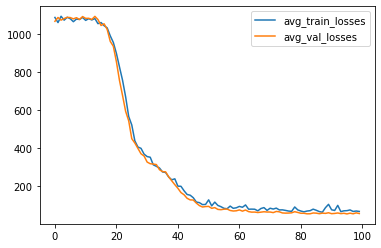

In [43]:
res_df[['avg_train_losses', 'avg_val_losses']].plot()

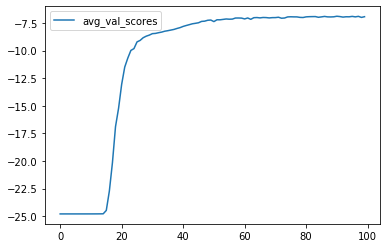

In [44]:
res_df[['avg_val_scores']].plot()

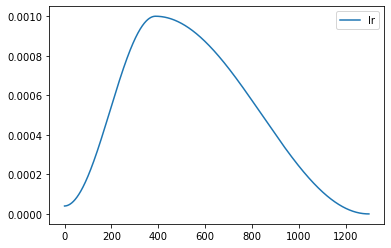

In [45]:
lr_df.plot()

In [46]:
res_df[['avg_val_scores']].max()

avg_val_scores   -6.893866
dtype: float64

#### Training

In [47]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)
EPOCHS=800

In [48]:
def convert_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32).to(device)

In [49]:
test_values = convert_to_tensor(submission_df[FE])
test_values.shape

torch.Size([730, 9])

In [50]:
pe = np.zeros((test_values.shape[0], 3))
pred = np.zeros((train_df.shape[0], 3))
pred.shape

(1542, 3)

In [51]:
def predict(features, model):
    return model(features).detach().cpu().numpy()

In [52]:
%%time

res_dfs = []
for cnt, (tr_idx, val_idx) in tqdm(enumerate(kf.split(X)), total=NFOLD):
    X_train, y_train = X.loc[tr_idx], y[tr_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    print(f"FOLD {cnt}", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    model = create_model()
    train_dl = create_dl(X_train, y_train)
    valid_dl = create_dl(X_valid, y_valid)
    res_df, _ = train_loop(EPOCHS, train_dl, valid_dl, model)
    res_dfs.append(res_df)
    pe += predict(test_values, model)
    pred[val_idx] = predict(convert_to_tensor(X_valid), model)

FOLD 0 (1233, 9) (1233,) (309, 9) (309,)



FOLD 1 (1233, 9) (1233,) (309, 9) (309,)



FOLD 2 (1234, 9) (1234,) (308, 9) (308,)



FOLD 3 (1234, 9) (1234,) (308, 9) (308,)



FOLD 4 (1234, 9) (1234,) (308, 9) (308,)




CPU times: user 3min 38s, sys: 17min 27s, total: 21min 5s
Wall time: 23min 34s


In [53]:
pe = pe / NFOLD

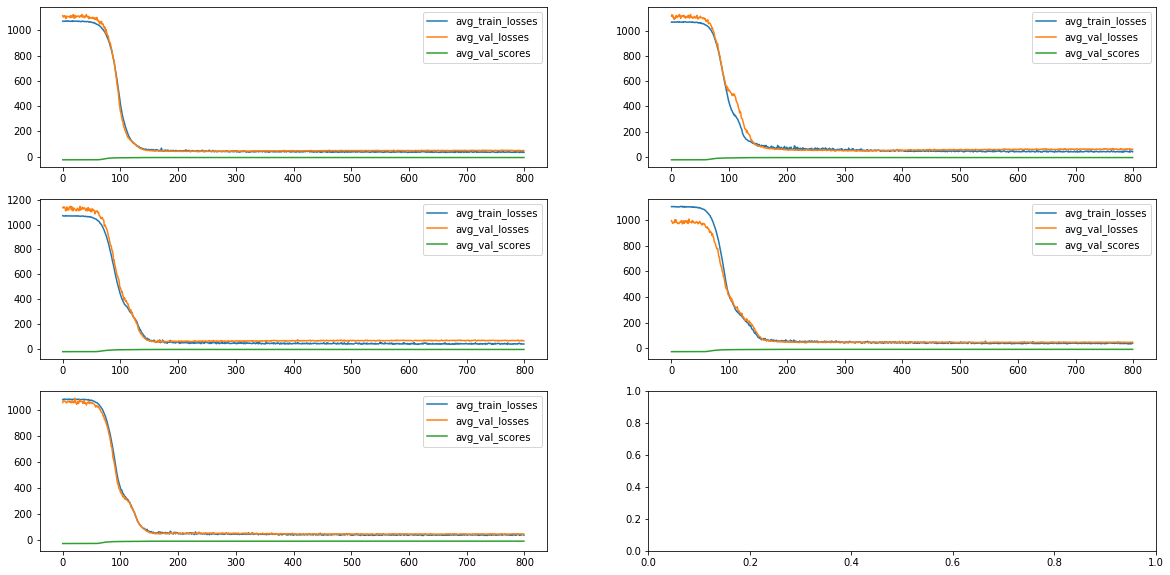

<Figure size 800x480 with 0 Axes>

In [54]:
from matplotlib.pyplot import figure

nrows = len(res_dfs) // 2 + 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
for r in range(nrows):
    for c in range(ncols):
        index = r * 2 + c
        if index < len(res_dfs):
            res_dfs[r * 2 + c].plot(ax=axes[r,c])

In [55]:
print("Mean validation score", np.mean([res_dfs[i]['avg_val_scores'][len(res_dfs[0]) - 1] for i in range(NFOLD)]))

Mean validation score -6.743656063079834


#### Prediction

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
sigma_opt, sigma_mean

In [ ]:
submission_df['FVC1'] = pe[:,1]
submission_df['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
submission_df.head(15)

In [ ]:
subm = submission_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].shape, subm.shape

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

In [ ]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.describe().T

In [ ]:
def replace_with_existing(df):
    for i in range(len(df)):
        patient_week_filter = subm['Patient_Week']==df.Patient[i]+'_'+str(df.Weeks[i])
        subm.loc[patient_week_filter, 'FVC'] = df.FVC[i]
        subm.loc[patient_week_filter, 'Confidence'] = 0.1

train_df = pd.read_csv(path/'train.csv', dtype = TRAIN_TYPES)
test_df = pd.read_csv(path/'test.csv', dtype = TRAIN_TYPES)
replace_with_existing(train_df)
replace_with_existing(test_df)

In [ ]:
subm[subm['Patient_Week'].str.find('ID00419637202311204720264') > -1].head(30)

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
pd.read_csv('submission.csv')

In [ ]:
!cat submission.csv